# Introduction to Neural Networks in JAX and Flax: Training regression tasks

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax # for optimization

## Example 1:

Learning $x \mapsto sin(x)$ with FLAX

In [2]:
class Flax_NN(nn.Module):
  hidden_sizes : list[int]
  output_neurons: int

  @nn.compact # decorator to define submodules (e.g. Dense, Conv) inline
  def __call__(self,x):
    # note: number of input neurons will be defined by the shape of x when calling the network for the first time!
    for size in self.hidden_sizes:
      x = nn.Dense(features=size)(x)
      x = nn.tanh(x)
    x = nn.Dense(features=self.output_neurons)(x)
    return x

In [3]:
model = Flax_NN(hidden_sizes = [16,8], output_neurons=1)
x = jnp.array([0.1])

# Parameter initialization:

key = jax.random.key(42)
params = model.init(key, x)
y = model.apply(params, x) 
print(y)

[-0.06976063]


In [4]:
# define a cost function (squared error)
def cost(params,x,y_target):
  y_pred = model.apply(params,x)
  return jnp.sum( ( y_pred - y_target )**2 )  # y_pred.shape = (output_dim,) and y_target.shape = (output_dim,)

In [5]:
# batches:
batched_cost=vmap(cost,in_axes=(None,0,0)) # we will have: y_pred.shape = (batch_size, output_dim) and y_target.shape = (batch_size, output_dim)

In [6]:
# batched_cost returns an array of shape (batch_size,)
# want to average the cost over the batches to return a scalar
def average_cost(params,x,y_target):
    return jnp.average(batched_cost(params,x,y_target))

In [7]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

In [8]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

In [9]:
def make_batch(batch_size):
    samples = jnp.linspace(-jnp.pi, jnp.pi, batch_size)[:, None] # produces a shape (batch_size, 1), instead of (batch_size,)
    return samples, jnp.sin(samples) 

In [10]:
# now you can run a training loop:
num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # produce a new batch (inputs x, desired outputs y):
  x,y = make_batch(batch_size)  # x.shape = (batch_size, input_dim)  and  y.shape = (batch_size, output_dim)

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

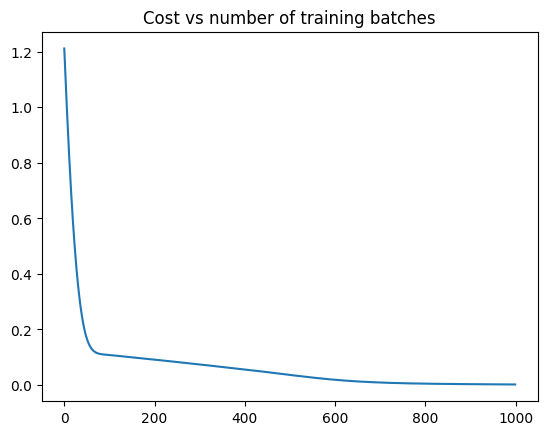

In [11]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

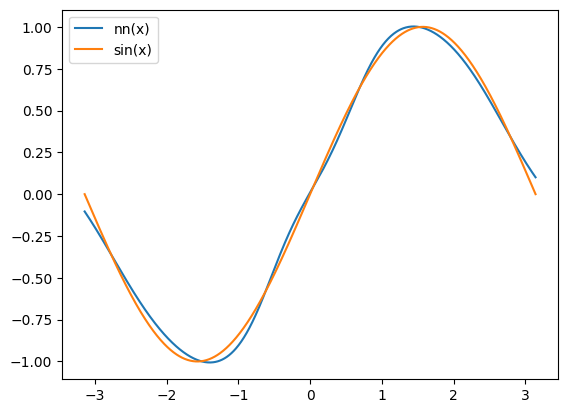

In [12]:
input_batch = jnp.linspace(-jnp.pi, jnp.pi, 1000)[:, None]  # shape (1000, 1)
output_batch = model.apply(params, input_batch) 


plt.plot(input_batch[:,0], output_batch, label='nn(x)')
plt.plot(input_batch[:,0], np.sin(input_batch[:,0]), label='sin(x)')
plt.legend()
plt.show()

### Exercises:

a) Investigate how the network generalizes out of the regression boundary $(-\pi,\pi)$

b) How does this change for larger/smaller networks ?

c) Train a MLP implemented from scratch with JAX (without usign FLAX) on the same regression task.

d) Try to use a different square norm, e.g. $\| f \|^2_p$, as a loss function. Can we use $\| f \|^2_\infty$?

## Example 2

Learning a function $f:\R^2 \to \R$

In [13]:
network = Flax_NN(hidden_sizes=[16,16,8], output_neurons=1)  # get an instance of the "Network" class
x = jnp.zeros((2,)) # dummy input for initialization
key = jax.random.key(47) # get a random key
key, subkey = jax.random.split(key)
params = network.init(subkey, x) # randomly initialize parameters

In [14]:
# Target function from R^2 to R
def myFunc(x):
    r2=x[:,0]**2+x[:,1]**2
    batch_size=jnp.shape(x)[0]
    return jnp.reshape(jnp.exp(-10*r2), (batch_size,1)) # to get proper shape

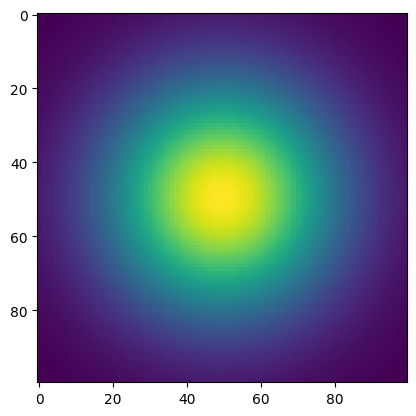

In [15]:
# Visualizing our target function
n_pixels=100
values=jnp.linspace(-0.5,0.5,n_pixels)
x0,x1=jnp.meshgrid(values,values)
x=jnp.stack([x0,x1],axis=-1)

myFunc_batched = vmap(myFunc, in_axes=(0))
result=myFunc_batched(x) # shape (n_pixels,n_pixels,1)

plt.imshow(result[:,:,0])
plt.show()

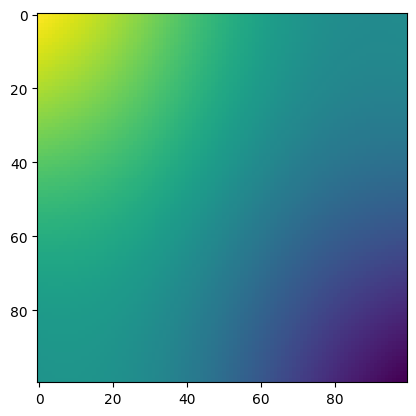

In [16]:
# Plot network function (before training)
n_pixels=100
values=jnp.linspace(-0.5,0.5,n_pixels)
x0,x1=jnp.meshgrid(values,values)
x=jnp.stack([x0,x1],axis=-1)

result=network.apply(params,x) # shape (n_pixels,n_pixels,1)

plt.imshow(result[:,:,0])
plt.show()

In [17]:
def make_batch(key, batch_size):
    input_coord = jax.random.uniform(key, minval=-0.5,maxval=+0.5,shape=(batch_size,2))
    output = myFunc(input_coord)
    return input_coord, output

In [18]:
def cost(params, x, y_target):
    y_pred = network.apply(params, x)
    return jnp.sum((y_pred - y_target)**2)

In [19]:
batched_cost = vmap(cost, in_axes=(None, 0, 0))

In [20]:
# average cost per batch
def average_cost_per_batch(params, x, y_target): # x and y_target are batched
    return jnp.average(batched_cost(params, x, y_target))

In [21]:
batched_value_and_grad_cost = jit(value_and_grad(average_cost_per_batch))

In [22]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

In [23]:
# Training Loop
num_batches = 1000
batch_size = 32
cost_history = []

for train_step in range(num_batches):
    # generate a random batch
    key, subkey = jax.random.split(key)
    x, y_target = make_batch(subkey, batch_size)

    # get cost and grad
    cost, grads = batched_value_and_grad_cost(params, x, y_target)

    # get params' updates and the optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    cost_history.append(cost)


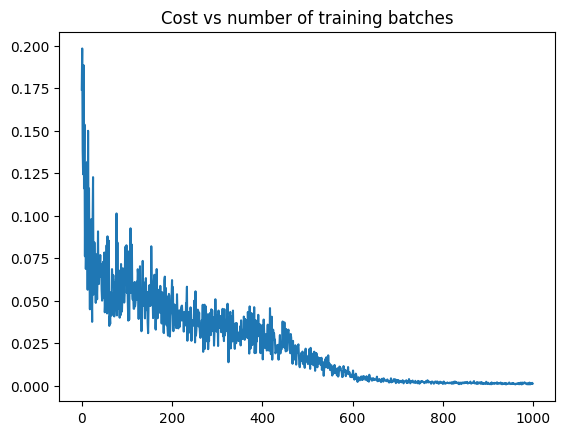

In [24]:

plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

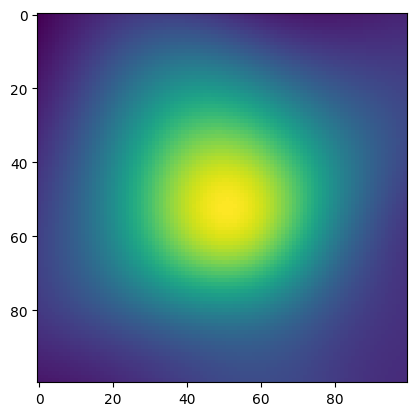

In [25]:
n_pixels=100
values=jnp.linspace(-0.5,0.5,n_pixels)
x0,x1=jnp.meshgrid(values,values)
x=jnp.stack([x0,x1],axis=-1)

result=network.apply(params,x) # shape (n_pixels,n_pixels,1)

plt.imshow(result[:,:,0])
plt.show()